# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.
/home/alfredotedesco/.pyenv/versions/3.5.9/envs/deep-359/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alfredotedesco/.pyenv/versions/3.5.9/envs/deep-359/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alfredotedesco/.pyenv/versions/3.5.9/envs/deep-359/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np

In [2]:
%pylab inline
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from copy import copy
from collections import Counter
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


First of all, you have you have to read the data. Run the cell below to unpack data.

In [3]:
from get_data import unpack
unpack('Face_Recognition_data.zip')

In [4]:
os.getcwd()

'/home/alfredotedesco/PycharmProjects/deep-learning-computer-vision/week4/face-recognition-task'

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [5]:
def load_image_data(dir_name = 'Face_Recognition_data/image_classification'):
    # ytrain
    df = pd.read_csv(dir_name+'/train/y_train.csv')
    y_train = dict(zip(df['filename'].values, df['class_id'].values))

    x_train = dict()
    #x_train.keys() = y_train.keys()
    # xtrain images
    for f in y_train.keys():
        x_train[f] = cv2.imread(dir_name+'/train/images/'+f, cv2.IMREAD_COLOR )[:,:,::-1]
    
    #xtest
    fnames_test = os.listdir(dir_name+'/test/images')
    x_test = dict()
    for f in fnames_test:
        x_test[f] = cv2.imread(dir_name+'/test/images/'+f, cv2.IMREAD_COLOR )[:,:,::-1]
    #ytest 
    df = pd.read_csv(dir_name+'/test/y_test.csv')
    y_test = dict(zip(df['filename'].values, df['class_id'].values))
    
    return x_train, y_train, x_test, y_test

In [6]:
x_train, y_train, x_test, y_test = load_image_data()
print('%d'%len(x_train), '\ttraining images')
print('%d'%len(x_test), '\ttesting images')

661 	training images
808 	testing images


In [7]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.choice(np.array(list(data.keys())), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(np.array(function([data[i]])))
        plt.title(labels[i])
    plt.show()

In [8]:
x_train['0.jpg'].shape

(242, 242, 3)

In [9]:
x_train['0.jpg']

array([[[ 89,  90,  92],
        [ 87,  88,  90],
        [ 87,  87,  89],
        ...,
        [ 11,  10,  24],
        [  9,   8,  22],
        [  7,   6,  20]],

       [[ 94,  95,  99],
        [ 92,  93,  95],
        [ 92,  91,  96],
        ...,
        [ 12,  11,  25],
        [ 10,   9,  23],
        [  8,   8,  20]],

       [[100, 103, 108],
        [101, 105, 108],
        [102, 103, 108],
        ...,
        [ 10,  12,  24],
        [  9,   9,  21],
        [  7,   7,  17]],

       ...,

       [[152, 105,   1],
        [150, 103,   0],
        [150, 101,   0],
        ...,
        [155, 164, 161],
        [155, 161, 159],
        [155, 161, 159]],

       [[156, 107,   2],
        [156, 107,   2],
        [155, 106,   1],
        ...,
        [158, 164, 162],
        [156, 162, 160],
        [155, 161, 159]],

       [[162, 114,   6],
        [164, 116,   8],
        [165, 117,   9],
        ...,
        [158, 164, 162],
        [156, 162, 160],
        [155, 161, 159]]

That is how the data looks like.

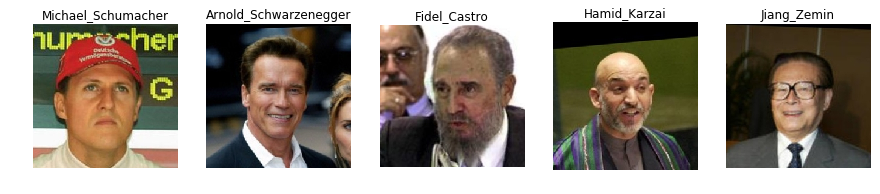

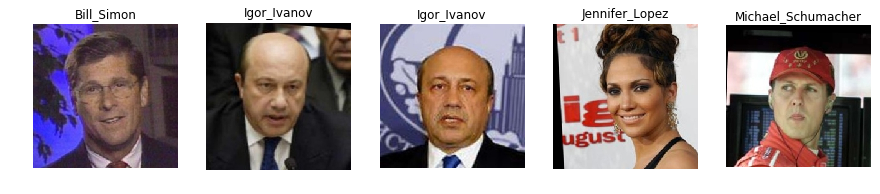

In [10]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [11]:
def load_video_data(dir_name = 'Face_Recognition_data/video_classification'):
    # xtrain images
    fnames_train = os.listdir(dir_name+'/train/images')
    x_train = dict()
        
    for f in fnames_train:
        x_train[f] = cv2.imread(dir_name+'/train/images/'+f, cv2.IMREAD_COLOR )[:,:,::-1]
    
    # ytrain
    df = pd.read_csv(dir_name+'/train/y_train.csv')
    y_train = dict(zip(df['filename'].values, df['class_id'].values))
       
    
    #xtest
    fnames_test = os.listdir(dir_name+'/test/videos')
    x_test = dict()
    for f in fnames_test:
        x_test[f] = []        
        for f2 in os.listdir(dir_name+'/test/videos/'+f):
            x_test[f].append(cv2.imread(dir_name+'/test/videos/'+f+'/'+f2, cv2.IMREAD_COLOR )[:,:,::-1])
    #ytest 
    df = pd.read_csv(dir_name+'/test/y_test.csv')
    y_test = dict(zip(df['filename'].values.astype(str), df['class_id'].values))
    
    return x_train, y_train, x_test, y_test

In [12]:
video_train, train_labels, video_test, test_labels = load_video_data()
print('%d'%len(video_train), '\ttraining images')
print('%d'%len(video_test), '\ttesting videos')

729 	training images
70 	testing videos


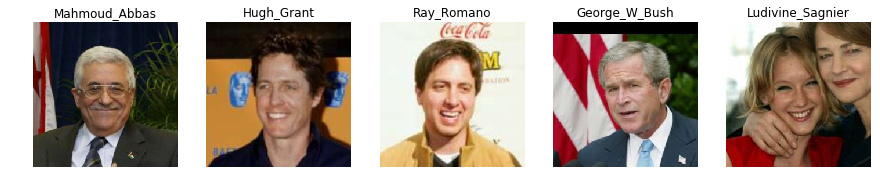

In [13]:
visualize(video_train, train_labels)

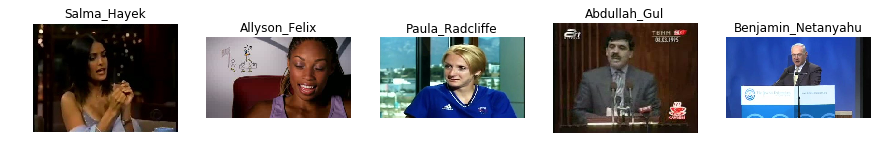

In [14]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

In [29]:
from skimage.feature import Cascade
from skimage import data
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_face_detection.html

# Load the trained file from the module root.
trained_file = data.lbp_frontal_face_cascade_filename()

# Initialize the detector cascade.
detector = Cascade(trained_file)


def preprocess_imgs(x, is_dict=True):
    """Your implementation"""
    # as seen on the forums, these models are not perfect and should be really fine tuned to be reused.
    # Hence I use the one used in the first week.
    def get_face(image):
        detected = detector.detect_multi_scale(img=image, # returns a list of dicts
                                                   scale_factor=1.2,
                                                   step_ratio=1,
                                                   min_size=(70, 70),
                                                   max_size=(400, 400))
        return detected
    #this preprocessing also deletes the y if the face is not detected.
    if is_dict:
        to_delete = []

        for k, v in x.items():
            detected = get_face(v)
            
            if len(detected):
                height = detected[0]['height']
                width = detected[0]['width']
                c = detected[0]['c']
                r = detected[0]['r']
                v = v[r:r+height, c:c+width]  
                x[k] = cv2.resize((v), (224, 224))

            else:
                to_delete.append(k)

        for k in to_delete:
            x.pop(k)

        print('Retrieving', len(x.keys()), 'with ', len(to_delete), 'deleted')
        return x, to_delete
    
    else:
        returned_ims = []
        for i in range(len(x)):
            v = x[i]
            detected = get_face(x[i])
            if len(detected):
                height = detected[0]['height']
                width = detected[0]['width']
                c = detected[0]['c']
                r = detected[0]['r']
                v = v[r:r+height, c:c+width]  
                returned_ims.append(cv2.resize((v), (224, 224)))
        return np.array(returned_ims)
        



    

In [16]:
x_train, to_delete = preprocess_imgs(x_train)
for k in to_delete:
    y_train.pop(k)

Retrieving 629 with  32 deleted


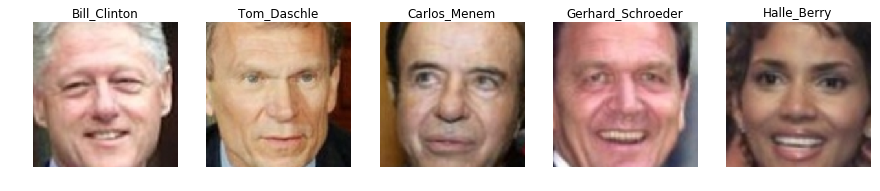

In [17]:
visualize(x_train, y_train)

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [18]:
import h5py
from keras.models import load_model
model = load_model('face_recognition_model.h5')
model.summary()








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
___

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [19]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    print()
    feature_extraction_model = Model(model.layers[0].input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [20]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)


(1, 4096)


In [21]:
assert x_train.keys() == y_train.keys()
assert x_test.keys() == y_test.keys()

In [22]:
assert video_train.keys() == train_labels.keys()
assert video_test.keys() == test_labels.keys()

### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [23]:
# check n classes
N_PEOPLE = 107

In [24]:
# THIS ONE DID NOT WORK, AS IT RETRIEVED THE FEATURES OF LAST LAYER - INTERMEDIATE LAYER SHOUDL HAVE BEEN USED

from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
from keras.layers import Dense, Input
import cv2
from os.path import join
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical 
from keras import optimizers

class Classifier():
    def __init__(self, nn_model, n_classes):
        """Your implementation"""
        self.nn_model = nn_model
        for layer in self.nn_model.layers:
            layer.trainable = False
        self.n_classes = n_classes
        # make model
        x = inp = Input(shape=(224,224,3))
        output = Dense(units=self.n_classes, activation='softmax')(nn_model(x))      
        self.full_model = Model(inputs=inp, outputs=output)
        
        self.__le = LabelEncoder()
        self.x_train = None
        self.y_train = None
        self.generator = ImageDataGenerator(horizontal_flip=True,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            zoom_range=0.1,
                                            samplewise_center = True,
                                            samplewise_std_normalization = True
                                           ) 
        self.full_model.summary()


    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        # 1. preprocess
        self.x_train = np.array([train_imgs[k] for k in train_imgs.keys()])
        self.y_train = np.array([train_labels[k] for k in train_imgs.keys()])
        # apply label encoder
        self.y_train = np.array(self.__le.fit_transform(self.y_train))
        print('Different classes are', len(np.unique(self.y_train)))
        print(max(self.y_train))
        self.y_train = to_categorical(self.y_train)
        # fit generator for data augmentation
        self.generator.fit(self.x_train#, augment=True, seed=4852, rounds=2)
        
        # compile model
        self.full_model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True), 
                                loss='categorical_crossentropy', 
                                metrics=['accuracy'])
        
        # fit model        
        self.full_model.fit_generator(self.generator.flow(self.x_train, self.y_train, batch_size=32),
                                      #epochs=50)
       # self.full_model.fit((self.x_train)/255, self.y_train, batch_size=32,
                           epochs=12)


    def classify_images(self, test_imgs):        
        pass

       
        
    def classify_videos(self, test_video):
        """Your implementation"""
        pass

SyntaxError: invalid syntax (<ipython-input-24-227303405b03>, line 53)

In [25]:
from sklearn.neighbors import KNeighborsClassifier as kNN
from skimage.io import imread
from keras.layers import Dense, Input
import cv2
from os.path import join
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import to_categorical 

class Classifier():
    def __init__(self, nn_model, n_classes):
        """Your implementation"""
        self.n_classes = n_classes
       
        self.__le = LabelEncoder()
        self.x_train = None
        self.y_train = None
            
        self.kNN = kNN(n_neighbors=5)
        self.predicted_x = None


    def fit(self, train_imgs, train_labels):
        """Your implementation"""
        # 1. preprocess
        self.x_train = np.array([train_imgs[k] for k in train_imgs.keys()])
        self.y_train = np.array([train_labels[k] for k in train_imgs.keys()])
        self.x_train = get_layer_output(self.x_train)
        # apply label encoder
        self.y_train = np.array(self.__le.fit_transform(self.y_train))
        print('Different classes are', len(np.unique(self.y_train)))
        print(max(self.y_train))
        
        self.kNN.fit(self.x_train, self.y_train)
        


    def classify_images(self, test_imgs, inv_transform=True):  
        preds = self.kNN.predict(get_layer_output(np.array([test_imgs[k] for k in test_imgs.keys()])))
        return self.__le.inverse_transform(preds) if inv_transform else preds
       
        
    def classify_videos(self, test_video):
        preds = []
        for k, imlist in test_video.items():
            prepr_ims = preprocess_imgs(imlist, is_dict=False)            
            preds.append(int(np.mean(self.kNN.predict(get_layer_output(prepr_ims)))))
        return self.__le.inverse_transform(preds) 

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [72]:
img_classifier = Classifier(model, N_PEOPLE)
img_classifier.fit(x_train, y_train)
#y_out = img_classifier.classify_images(x_test)


Different classes are 107
106


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [66]:
def check_test(output, gt):
    correct = 0.
    total = len(gt)
    for i in range(total):
        if output[i] == gt[i]:
            correct += 1
    accuracy = correct / total

    return 'Classification accuracy is %.4f' % accuracy

In [74]:
# preprocess x_test and y_test
x_test, to_delete = preprocess_imgs(x_test)
for k in to_delete:
    y_test.pop(k)

Retrieving 763 with  45 deleted


In [77]:
preds = img_classifier.kNN.predict(get_layer_output(np.array([x_test[k] for k in x_test.keys()])))
preds = img_classifier._Classifier__le.inverse_transform(preds)

In [78]:
check_test(preds, np.array([y_test[k] for k in x_test.keys()]))

'Classification accuracy is 0.8925'

### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [26]:
N_PEOPLE = len(np.unique(list(train_labels.values())))
N_PEOPLE

96

In [27]:
video_train, to_delete = preprocess_imgs(video_train)
for k in to_delete:
    train_labels.pop(k)

Retrieving 691 with  38 deleted


In [ ]:
video_classifier = Classifier(model, N_PEOPLE)
video_classifier.fit(video_train, train_labels)

In [52]:
from scipy.stats import mode
preds = []
to_delete = []
for k, imlist in video_test.items():
    prepr_ims = preprocess_imgs(imlist, is_dict=False)
    print('Current video', k)
    if len(prepr_ims):
        preds.append(mode(video_classifier.kNN.predict(get_layer_output(prepr_ims)), axis=None)[0][0])
    else:
        print('No face detected in video', k)
        preds.append(mode(test_labels.values(), axis=None)[0][0])
preds = video_classifier._Classifier__le.inverse_transform(preds)


Current video 4

Current video 66

Current video 46

Current video 40

Current video 8

Current video 31

Current video 48

Current video 55

Current video 57

Current video 65
No face detected in video 65
Current video 37

Current video 64

Current video 35

Current video 56

Current video 27

Current video 32

Current video 15

Current video 45

Current video 41

Current video 23

Current video 5

Current video 50

Current video 13

Current video 62

Current video 22

Current video 25

Current video 7

Current video 28

Current video 60

Current video 21

Current video 42

Current video 2

Current video 44

Current video 24

Current video 59

Current video 51

Current video 54

Current video 18

Current video 67

Current video 38

Current video 39

Current video 11

Current video 20

Current video 68

Current video 53

Current video 16

Current video 49

Current video 61

Current video 6

Current video 9

Current video 19

Current video 12

Current video 33

Current video 26

Current

TypeError: unorderable types: int() > dict_values()

In [62]:
print(preds)

[7, 85, 13, 29, 72, 2, 29, 63, 29, dict_values(['Angela_Bassett', 'Tom_Harkin', 'Thabo_Mbeki', 'Rick_Perry', 'Mahathir_Mohamad', 'Zhu_Rongji', 'Nick_Nolte', 'Mahathir_Mohamad', 'Gene_Robinson', 'Pedro_Malan', 'Benjamin_Netanyahu', 'Carrie-Anne_Moss', 'Pedro_Malan', 'James_Wolfensohn', 'Enrique_Bolanos', 'Alejandro_Toledo', 'Tom_Cruise', 'Jan_Ullrich', 'Kevin_Spacey', 'Elsa_Zylberstein', 'Jake_Gyllenhaal', 'Choi_Sung-hong', 'Leonid_Kuchma', 'Laura_Bush', 'Mahathir_Mohamad', 'Laura_Bush', 'Mahmoud_Abbas', 'Abdullah_Gul', 'Condoleezza_Rice', 'Salma_Hayek', 'Paul_ONeill', 'George_W_Bush', 'Sarah_Hughes', 'Nicanor_Duarte_Frutos', 'Maria_Soledad_Alvear_Valenzuela', 'Vladimir_Putin', 'Paula_Radcliffe', 'Allyson_Felix', 'Angela_Bassett', 'Benazir_Bhutto', 'William_Donaldson', 'Tom_Crean', 'Nestor_Kirchner', 'Colin_Montgomerie', 'Christine_Todd_Whitman', 'Kofi_Annan', 'Carla_Del_Ponte', 'William_Ford_Jr', 'Tom_Hanks', 'Eduardo_Duhalde', 'Jacques_Rogge', 'Charlton_Heston', 'Valery_Giscard_dEstai

In [63]:
preds[9] = 0
preds = video_classifier._Classifier__le.inverse_transform(preds)


In [67]:
check_test(preds, [(test_labels[k]) for k in video_test])

'Classification accuracy is 0.6232'

{'0': 'Nancy_Pelosi',
 '1': 'Paul_Wolfowitz',
 '10': 'Andy_Roddick',
 '11': 'Benazir_Bhutto',
 '12': 'Eduardo_Duhalde',
 '13': 'Leonid_Kuchma',
 '14': 'Choi_Sung-hong',
 '15': 'Kofi_Annan',
 '16': 'Colin_Montgomerie',
 '17': 'Bill_Clinton',
 '18': 'Vladimir_Putin',
 '19': 'Tom_Hanks',
 '2': 'Paul_ONeill',
 '20': 'William_Donaldson',
 '21': 'William_Ford_Jr',
 '22': 'Mahathir_Mohamad',
 '23': 'Elsa_Zylberstein',
 '24': 'George_W_Bush',
 '25': 'Laura_Bush',
 '26': 'Valery_Giscard_dEstaing',
 '27': 'Benjamin_Netanyahu',
 '28': 'Abdullah_Gul',
 '29': 'Bill_Frist',
 '3': 'Ray_Romano',
 '30': 'Mahmoud_Abbas',
 '31': 'Mahathir_Mohamad',
 '32': 'James_Wolfensohn',
 '33': 'Jake_Gyllenhaal',
 '34': 'Cameron_Diaz',
 '35': 'Carrie-Anne_Moss',
 '36': 'Tom_Hanks',
 '37': 'Pedro_Malan',
 '38': 'Allyson_Felix',
 '39': 'Angela_Bassett',
 '4': 'Angela_Bassett',
 '40': 'Thabo_Mbeki',
 '41': 'Kevin_Spacey',
 '42': 'Salma_Hayek',
 '43': 'Carrie-Anne_Moss',
 '44': 'Alejandro_Toledo',
 '45': 'Jan_Ullrich',
 